In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv("/kaggle/input/duplicate-question-pair/questions.csv")

In [2]:
import re
import pickle

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score

from difflib import SequenceMatcher

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Bidirectional,
    Dense, Concatenate, Dropout
)
from tensorflow.keras.models import Model


2026-02-02 18:10:28.471219: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770055828.689736      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770055828.758903      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770055829.308033      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770055829.308082      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770055829.308085      55 computation_placer.cc:177] computation placer alr

In [3]:
df = df.dropna(subset=["question1", "question2"])

print(df.shape)
df.head()

(404348, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[^a-z ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["question1"] = df["question1"].apply(clean_text)
df["question2"] = df["question2"].apply(clean_text)


In [5]:
!pip install -q transformers datasets accelerate


In [6]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score


In [7]:
class QPDataset(Dataset):
    def __init__(self, q1, q2, labels, tokenizer, max_len=64):
        self.q1 = q1
        self.q2 = q2
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.q1[idx],
            self.q2[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item


In [8]:
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-1

In [9]:
q1_train, q1_val, q2_train, q2_val, y_train, y_val = train_test_split(
    df["question1"].tolist(),
    df["question2"].tolist(),
    df["is_duplicate"].values,
    test_size=0.2,
    random_state=42
)


In [10]:
train_ds = QPDataset(q1_train, q2_train, y_train, tokenizer)
val_ds   = QPDataset(q1_val, q2_val, y_val, tokenizer)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=128)


In [11]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

epochs = 7
total_steps = epochs * len(train_loader)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()


In [12]:
patience = 3
best_val_loss = float("inf")
counter = 0

for epoch in range(epochs):

    # ---- TRAIN ----
    model.train()
    train_preds, train_labels = [], []
    train_loss_total = 0.0

    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        out = model(**batch)
        loss = out.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss_total += loss.item()

        preds = torch.argmax(out.logits, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(batch["labels"].cpu().numpy())

    train_loss = train_loss_total / len(train_loader)
    train_acc = accuracy_score(train_labels, train_preds)

    # ---- VALIDATE ----
    model.eval()
    val_preds, val_labels = [], []
    val_loss_total = 0.0

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}

            out = model(**batch)
            loss = out.loss

            val_loss_total += loss.item()

            preds = torch.argmax(out.logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(batch["labels"].cpu().numpy())

    val_loss = val_loss_total / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds)

    print(
        f"Epoch {epoch+1} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Train Acc: {train_acc:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )

    # ---- EARLY STOPPING ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        counter += 1
        print(f"No improvement. Counter: {counter}/{patience}")

        if counter >= patience:
            print("Early stopping triggered 🚨")
            break


Epoch 1 | Train Loss: 0.3645 | Val Loss: 0.2991 | Train Acc: 0.8300 | Val Acc: 0.8673
Epoch 2 | Train Loss: 0.2910 | Val Loss: 0.2873 | Train Acc: 0.8713 | Val Acc: 0.8775
Epoch 3 | Train Loss: 0.2590 | Val Loss: 0.2735 | Train Acc: 0.8872 | Val Acc: 0.8823
Epoch 4 | Train Loss: 0.2351 | Val Loss: 0.2701 | Train Acc: 0.9000 | Val Acc: 0.8862
Epoch 5 | Train Loss: 0.2169 | Val Loss: 0.2689 | Train Acc: 0.9085 | Val Acc: 0.8878
Epoch 6 | Train Loss: 0.2034 | Val Loss: 0.2722 | Train Acc: 0.9149 | Val Acc: 0.8897
No improvement. Counter: 1/3
Epoch 7 | Train Loss: 0.1944 | Val Loss: 0.2732 | Train Acc: 0.9195 | Val Acc: 0.8910
No improvement. Counter: 2/3


Loaded best model weights.
Generating predictions on validation set...

CLASSIFICATION REPORT
               precision    recall  f1-score   support

Not Duplicate       0.93      0.89      0.91     51240
    Duplicate       0.82      0.89      0.85     29630

     accuracy                           0.89     80870
    macro avg       0.88      0.89      0.88     80870
 weighted avg       0.89      0.89      0.89     80870



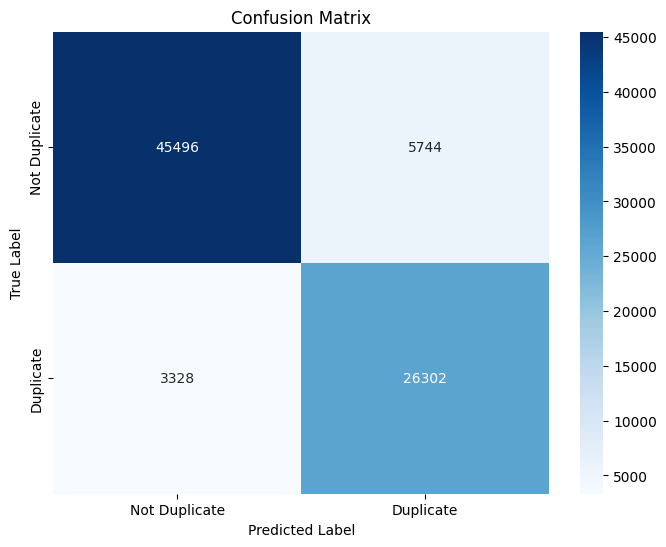

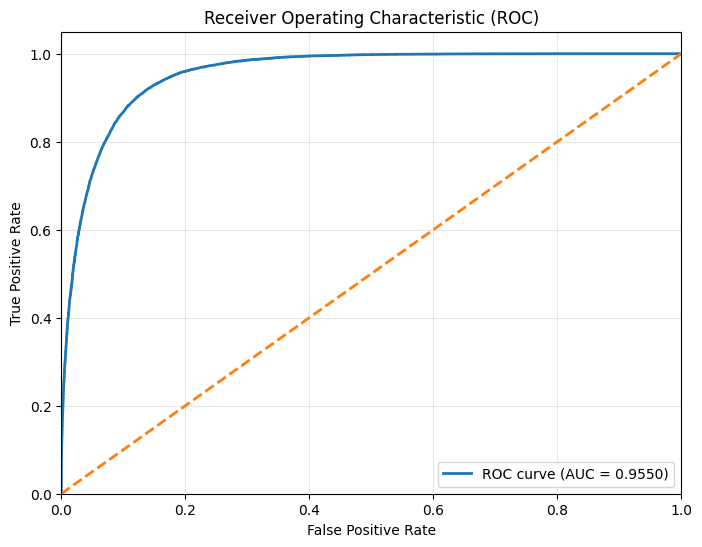


Final AUC: 0.9550


In [15]:
# ==============================
#  EVALUATION AFTER TRAINING
# ==============================

import numpy as np
import torch
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import os

# -------- 1. Load best model --------
if 'best_model.pt' in os.listdir():
    model.load_state_dict(torch.load("best_model.pt"))
    print("Loaded best model weights.")

model.to(device)
model.eval()

# -------- 2. Generate predictions --------
y_true = []
y_pred_classes = []
y_pred_probs = []

print("Generating predictions on validation set...")

with torch.no_grad():
    for batch in val_loader:   # <-- change to test_loader if you want final test results
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        logits = outputs.logits

        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)

        y_true.extend(batch["labels"].cpu().numpy())
        y_pred_classes.extend(preds.cpu().numpy())
        y_pred_probs.extend(probs[:, 1].cpu().numpy())  # prob of "Duplicate"

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred_classes = np.array(y_pred_classes)
y_pred_probs = np.array(y_pred_probs)

# -------- 3. Classification Report --------
print("\n" + "="*30)
print("CLASSIFICATION REPORT")
print("="*30)
print(
    classification_report(
        y_true,
        y_pred_classes,
        target_names=['Not Duplicate', 'Duplicate']
    )
)

# -------- 4. Confusion Matrix --------
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Not Duplicate', 'Duplicate'],
    yticklabels=['Not Duplicate', 'Duplicate']
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# -------- 5. ROC Curve + AUC --------
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"\nFinal AUC: {roc_auc:.4f}")
